In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [16]:
eth = pd.read_csv("../ETH_data.csv", parse_dates=["date"], index_col="date")
print("Shape:", eth.shape)
print("\nColumns:", eth.columns.tolist())
print("\nDate range:", eth.index.min().date(), "→", eth.index.max().date())
print("\nMissing values (top 10):")
print(eth.isna().mean().sort_values(ascending=False).head(10))


Shape: (3177, 49)

Columns: ['open', 'high', 'low', 'close', 'volume', 'log_price', 'log_ret', 'ret_5d', 'ret_20d', 'vol_20d', 'mom_10d', 'sma10', 'sma20', 'sma50', 'SP500', 'SP500_log_price', 'SP500_lret', 'SP500_ret_5d', 'SP500_ret_20d', 'SP500_vol_20d', 'SP500_mom_10d', 'SP500_sma10', 'SP500_sma20', 'SP500_sma50', 'GOLD', 'GOLD_log_price', 'GOLD_lret', 'GOLD_ret_5d', 'GOLD_ret_20d', 'GOLD_vol_20d', 'GOLD_mom_10d', 'GOLD_sma10', 'GOLD_sma20', 'GOLD_sma50', 'DXY', 'DXY_log_price', 'DXY_lret', 'DXY_ret_5d', 'DXY_ret_20d', 'DXY_vol_20d', 'DXY_mom_10d', 'DXY_sma10', 'DXY_sma20', 'DXY_sma50', 'ret_1d_arith', 'y_price_next', 'y_log_price_next', 'y_ret_1d_next', 'y_log_ret_1d_next']

Date range: 2017-03-15 → 2025-11-24

Missing values (top 10):
open              0.0
GOLD_log_price    0.0
GOLD_ret_5d       0.0
GOLD_ret_20d      0.0
GOLD_vol_20d      0.0
GOLD_mom_10d      0.0
GOLD_sma10        0.0
GOLD_sma20        0.0
GOLD_sma50        0.0
DXY               0.0
dtype: float64


<Figure size 2000x1800 with 0 Axes>

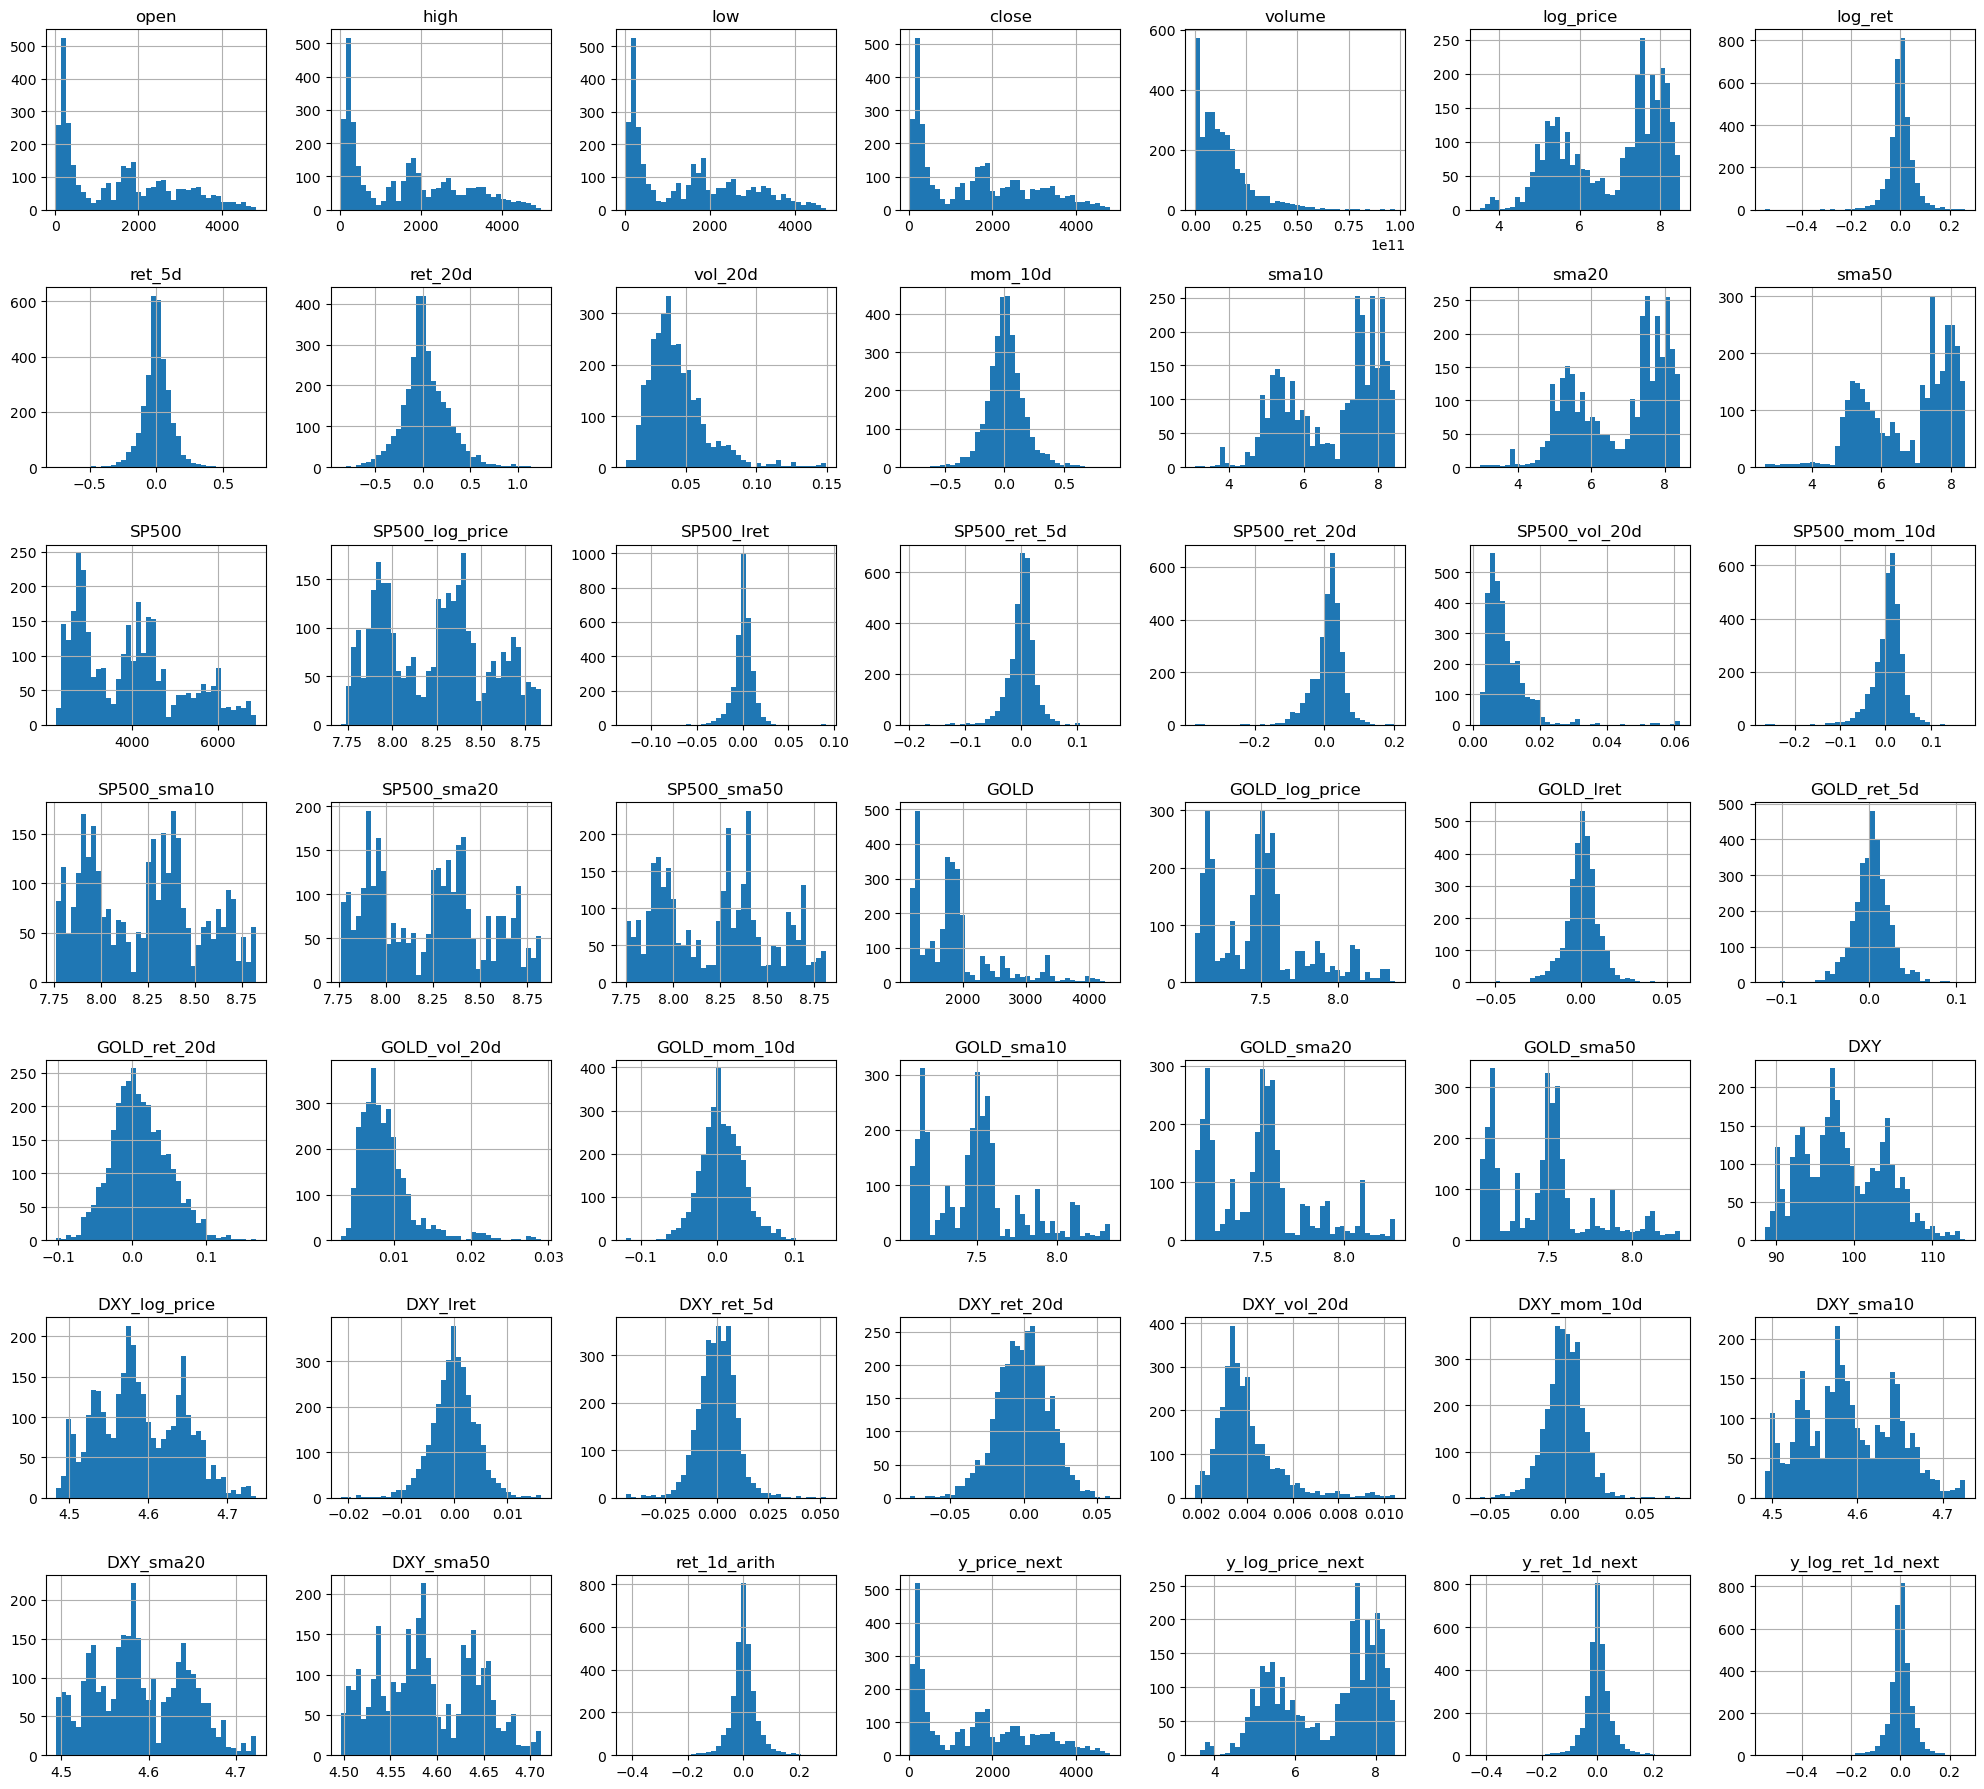

In [4]:
plt.figure(figsize=(20, 18))
eth.hist(figsize=(20, 18), bins=40)
plt.tight_layout()
plt.show()

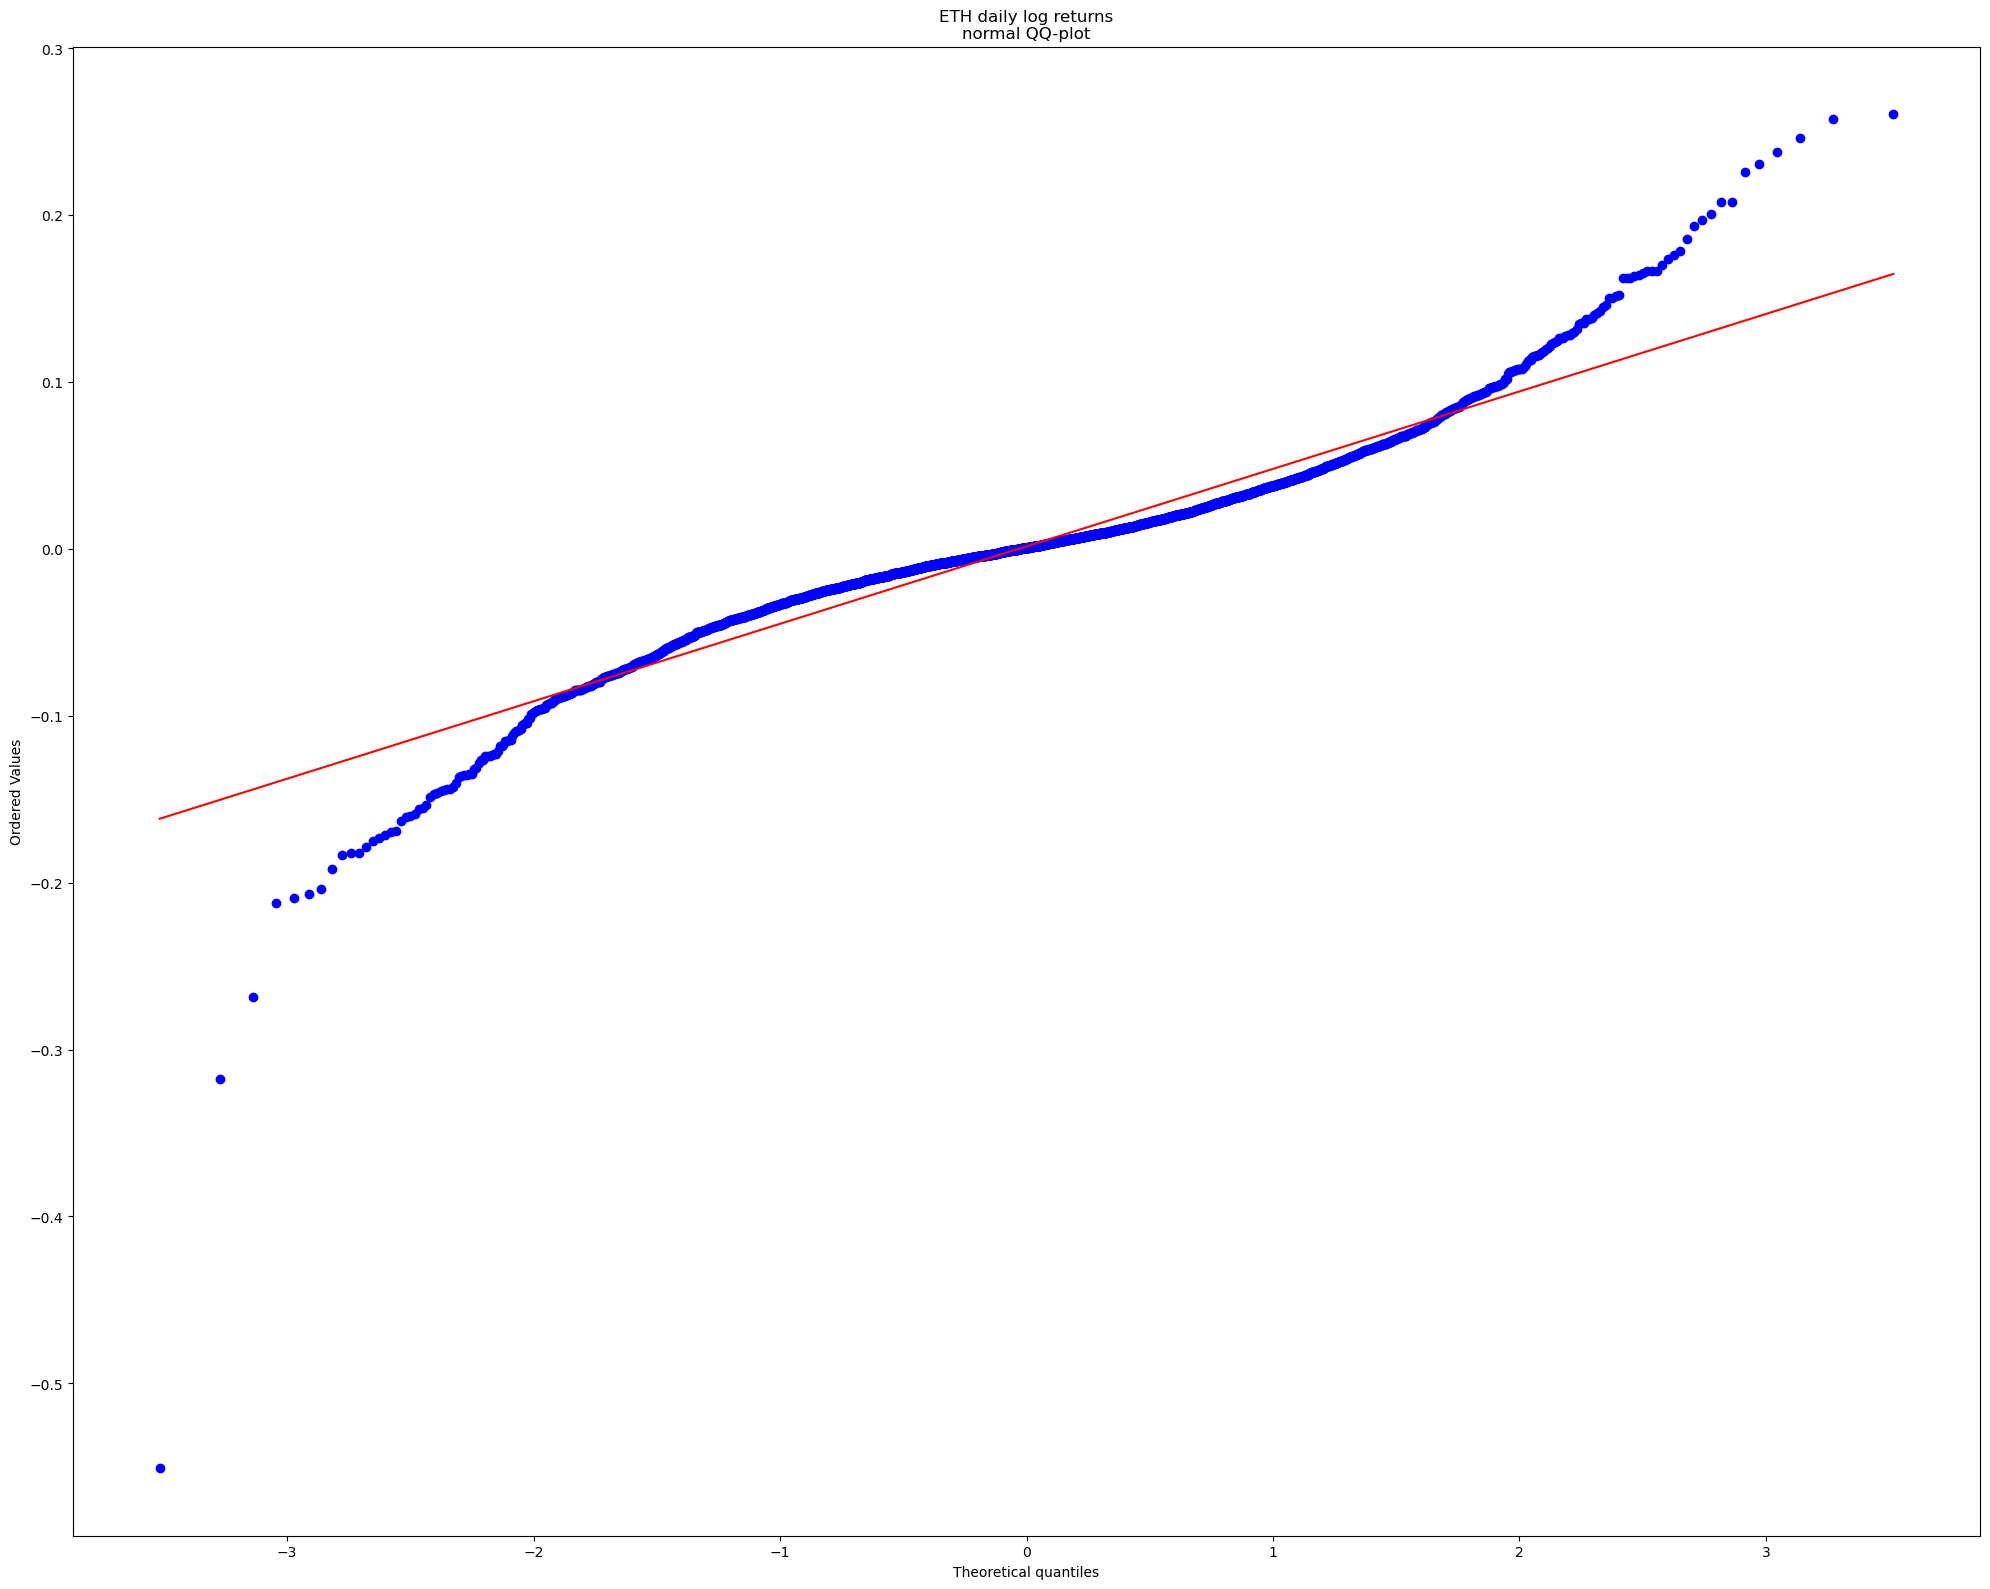

9.201834742892327

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 选择 eth 日 log return

plt.figure(figsize=(20, 16))
stats.probplot(eth["log_ret"], dist="norm", plot=plt)
plt.title("ETH daily log returns\nnormal QQ-plot")
plt.tight_layout()
plt.show()

eth["log_ret"].kurtosis()

In [17]:
eth["vol_20d"].skew()

1.7002931922716475

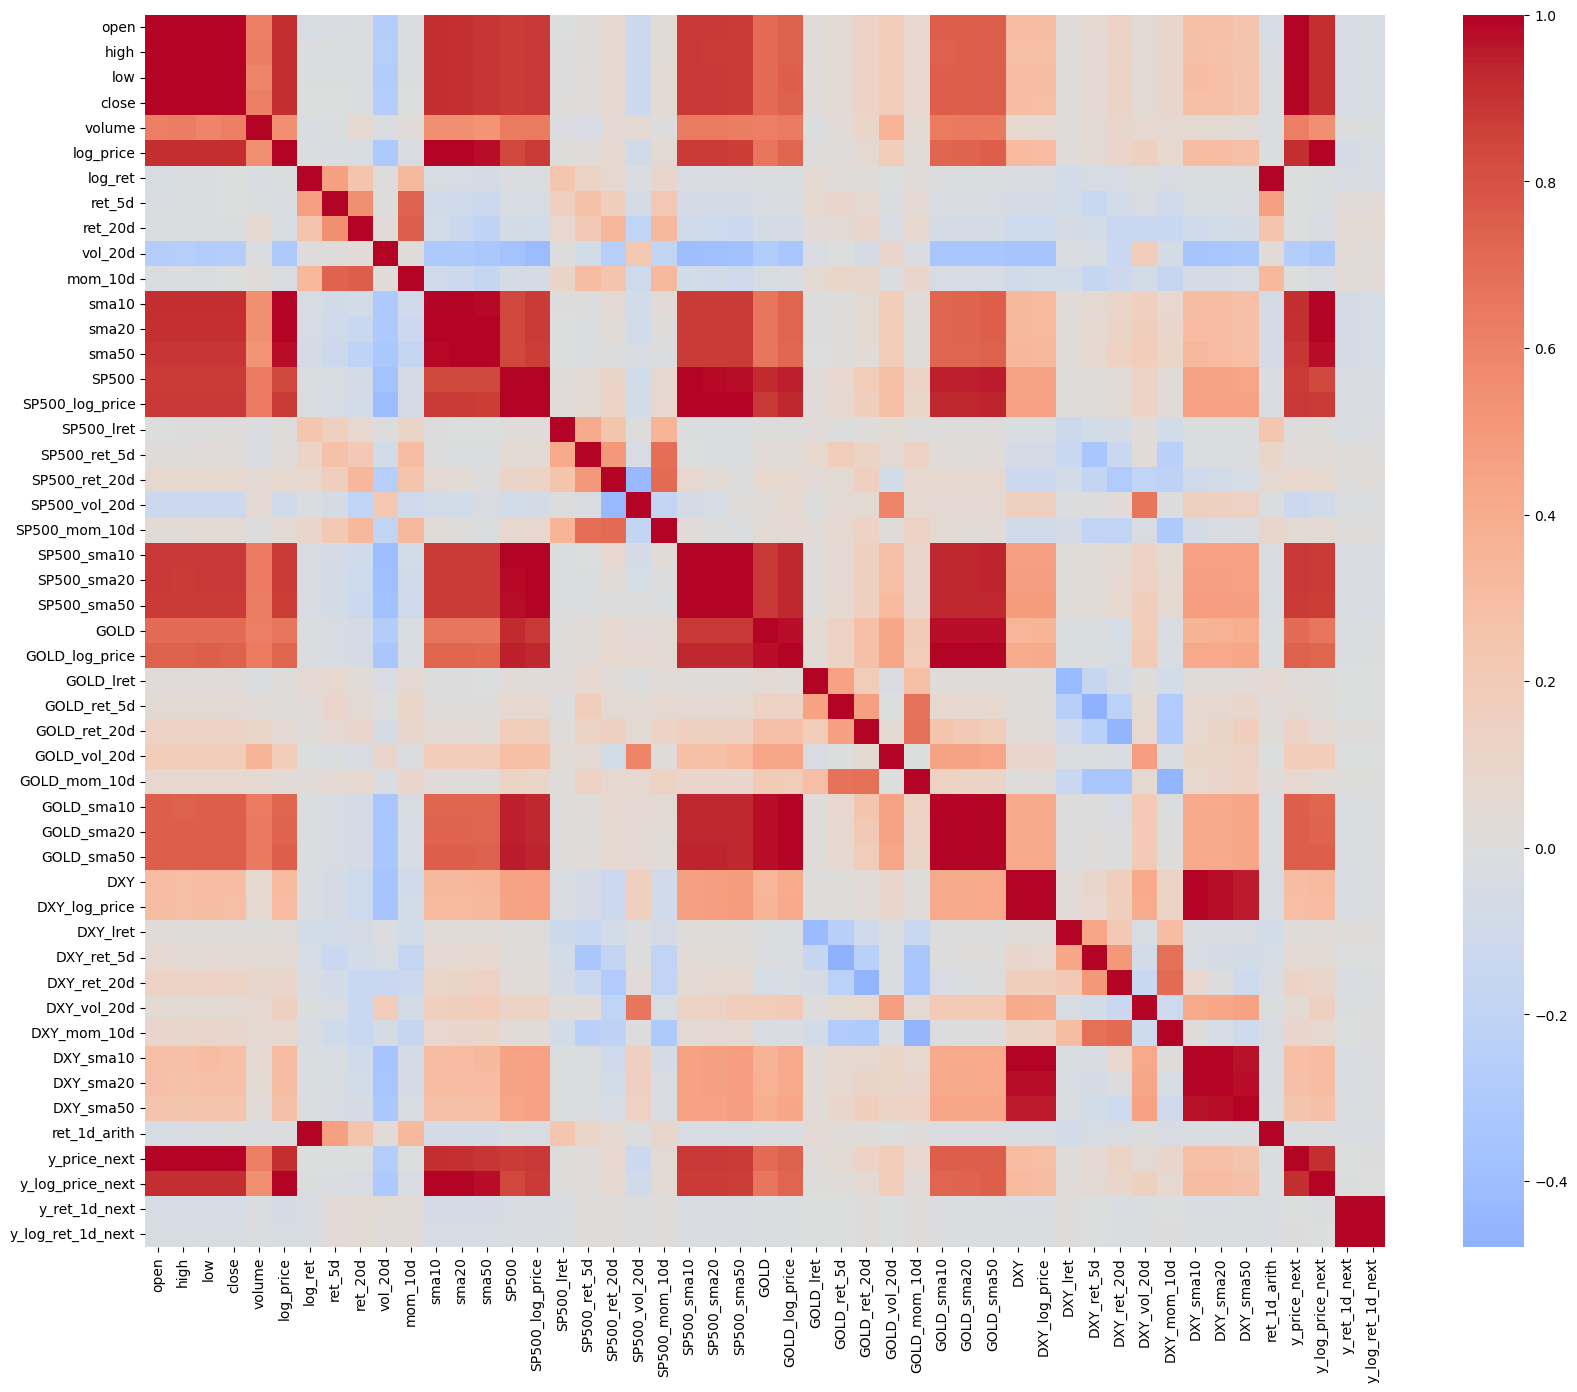

In [6]:
plt.figure(figsize=(20, 16))
sns.heatmap(eth.corr(), cmap="coolwarm", center=0)
plt.show()


In [7]:
target_cols = [
    "y_price_next",
    "y_log_price_next",
    "y_ret_1d_next",
    "y_log_ret_1d_next"
]

corr = eth.corr()

for target in target_cols:
    print(f"\n===== Correlation with {target} =====")

    corr_to_y = corr[target].drop(target).sort_values()

    print("\nTop negative correlations:")
    print(corr_to_y.head(10))

    print("\nTop positive correlations:")
    print(corr_to_y.tail(10))




===== Correlation with y_price_next =====

Top negative correlations:
vol_20d             -0.269474
SP500_vol_20d       -0.127665
ret_1d_arith        -0.007987
ret_20d             -0.005238
y_ret_1d_next       -0.004859
mom_10d             -0.003706
ret_5d              -0.003378
log_ret             -0.001059
y_log_ret_1d_next    0.002030
SP500_lret           0.008649
Name: y_price_next, dtype: float64

Top positive correlations:
SP500_log_price     0.880383
sma50               0.892990
sma20               0.909439
sma10               0.914087
log_price           0.917831
y_log_price_next    0.918791
open                0.996199
low                 0.997007
high                0.997197
close               0.998019
Name: y_price_next, dtype: float64

===== Correlation with y_log_price_next =====

Top negative correlations:
vol_20d             -0.306406
SP500_vol_20d       -0.091373
ret_20d             -0.038029
mom_10d             -0.030566
ret_5d              -0.022359
ret_1d_arith    

In [8]:
from xgboost import XGBRegressor

target_cols = [
    "y_price_next",
    "y_log_price_next",
    "y_ret_1d_next",
    "y_log_ret_1d_next",
]

# features are all non-target columns
X = eth.drop(columns=target_cols)

for target in target_cols:
    y = eth[target]

    print(f"\n===== XGBoost feature importance for {target} =====")

    model = XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror",
    )

    model.fit(X, y)

    importances = pd.Series(model.feature_importances_, index=X.columns)
    print("\nTop 15 features:")
    print(importances.sort_values(ascending=False).head(15))


===== XGBoost feature importance for y_price_next =====

Top 15 features:
log_price          0.454685
close              0.367794
low                0.121661
high               0.023360
open               0.011561
sma10              0.005990
SP500_sma50        0.003606
GOLD_sma20         0.000612
SP500              0.000606
SP500_log_price    0.000552
DXY                0.000464
DXY_log_price      0.000452
GOLD_sma50         0.000430
SP500_sma10        0.000416
GOLD_log_price     0.000401
dtype: float32

===== XGBoost feature importance for y_log_price_next =====

Top 15 features:
log_price      0.393254
high           0.234179
close          0.226821
open           0.089725
low            0.045745
DXY_sma20      0.001989
DXY_sma10      0.001713
SP500_sma10    0.000955
sma10          0.000942
DXY_sma50      0.000770
sma20          0.000450
SP500_sma50    0.000388
SP500_sma20    0.000347
SP500          0.000307
GOLD_sma50     0.000221
dtype: float32

===== XGBoost feature importance fo

In [9]:


regimes = {
    "2017-2019": ("2017-01-01", "2019-12-31"),
    "2020-2021": ("2020-01-01", "2021-12-31"),
    "2022-2025": ("2022-01-01", eth.index.max().strftime("%Y-%m-%d")),
}

print("Regime summary:")
for name, (start, end) in regimes.items():
    sub = eth.loc[start:end]
    print(f"- {name}: {start} -> {end}, rows = {len(sub)}")


Regime summary:
- 2017-2019: 2017-01-01 -> 2019-12-31, rows = 1022
- 2020-2021: 2020-01-01 -> 2021-12-31, rows = 731
- 2022-2025: 2022-01-01 -> 2025-11-24, rows = 1424


In [10]:
def corr_in_regime(df, target, start, end, top=10):
    sub = df.loc[start:end]
    corr = sub.corr()[target].drop(target).sort_values()
    
    return corr.head(top), corr.tail(top)


In [11]:
target = "y_log_price_next"

for name, (start, end) in regimes.items():
    print(f"\n===== Correlation with {target} in {name} =====")

    neg, pos = corr_in_regime(eth, target, start, end, top=10)

    print("\nTop negative correlations:")
    print(neg)

    print("\nTop positive correlations:")
    print(pos)



===== Correlation with y_log_price_next in 2017-2019 =====

Top negative correlations:
DXY_sma20       -0.821853
DXY_sma10       -0.818714
DXY             -0.814116
DXY_log_price   -0.812058
DXY_sma50       -0.800333
GOLD_mom_10d    -0.097403
GOLD_ret_5d     -0.084388
GOLD_ret_20d    -0.083519
volume          -0.076834
GOLD_lret       -0.044211
Name: y_log_price_next, dtype: float64

Top positive correlations:
DXY_vol_20d     0.155098
high            0.903286
open            0.904950
close           0.908049
low             0.909184
y_price_next    0.910954
sma50           0.911227
sma20           0.967975
sma10           0.984815
log_price       0.996720
Name: y_log_price_next, dtype: float64

===== Correlation with y_log_price_next in 2020-2021 =====

Top negative correlations:
DXY_sma50       -0.766203
DXY_sma20       -0.669089
DXY_sma10       -0.633720
DXY             -0.608242
DXY_log_price   -0.605658
SP500_vol_20d   -0.518592
GOLD_vol_20d    -0.399986
DXY_vol_20d     -0.373729


In [12]:
primary_target = "y_log_ret_1d_next"

for name, (start, end) in regimes.items():
    print(f"\n===== Correlation with {primary_target} in {name} =====")

    neg, pos = corr_in_regime(eth, primary_target, start, end, top=10)

    print("\nTop negative correlations:")
    print(neg)

    print("\nTop positive correlations:")
    print(pos)



===== Correlation with y_log_ret_1d_next in 2017-2019 =====

Top negative correlations:
SP500_sma50       -0.102950
sma50             -0.102612
SP500_sma10       -0.099127
SP500_log_price   -0.098366
sma20             -0.097013
SP500_sma20       -0.096384
SP500             -0.096157
sma10             -0.090556
log_price         -0.081668
low               -0.068319
Name: y_log_ret_1d_next, dtype: float64

Top positive correlations:
DXY_log_price    0.037195
DXY              0.037401
DXY_sma10        0.043756
DXY_sma20        0.048737
DXY_sma50        0.062527
vol_20d          0.066639
mom_10d          0.068783
ret_5d           0.071428
ret_20d          0.095695
y_ret_1d_next    0.997903
Name: y_log_ret_1d_next, dtype: float64

===== Correlation with y_log_ret_1d_next in 2020-2021 =====

Top negative correlations:
log_ret        -0.099994
ret_1d_arith   -0.090731
close          -0.054591
low            -0.054375
high           -0.051256
SP500_lret     -0.051206
open           -0.048886

In [13]:
# protential signal：mom_10d，ret_20d, vol_20d, SP500_ret_5d, DXY_lret

signal = eth["mom_10d"]
future_ret = eth["y_log_ret_1d_next"]

data = pd.DataFrame({"signal": signal, "future_ret": future_ret})

data["bucket"] = pd.qcut(data["signal"], 5, labels=False)

bucket_mean = data.groupby("bucket")["future_ret"].mean()
bucket_hit  = data.groupby("bucket")["future_ret"].apply(lambda x: (x > 0).mean())

print("Average next-day log return by momentum bucket:")
print(bucket_mean)

print("\nHit rate (P(future_ret > 0)) by bucket:")
print(bucket_hit)


Average next-day log return by momentum bucket:
bucket
0   -0.001315
1   -0.001910
2    0.000960
3    0.001391
4    0.007844
Name: future_ret, dtype: float64

Hit rate (P(future_ret > 0)) by bucket:
bucket
0    0.522013
1    0.505512
2    0.496063
3    0.475591
4    0.551887
Name: future_ret, dtype: float64


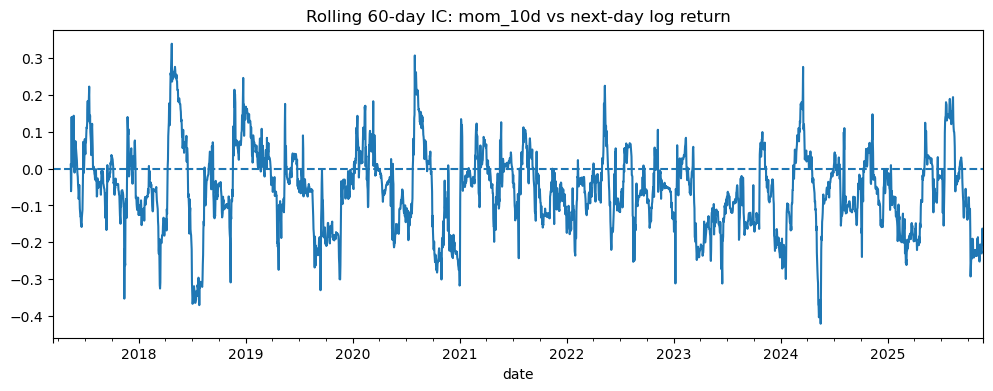

IC summary:
count    3118.000000
mean       -0.058504
std         0.109461
min        -0.421469
25%        -0.126623
50%        -0.056769
75%         0.010074
max         0.339211
Name: (mom_10d, y_log_ret_1d_next), dtype: float64


In [14]:
window = 60 

ic_series = (
    eth[["mom_10d", "y_log_ret_1d_next"]]
    .dropna()
    .rolling(window)
    .corr()
    .unstack()
    .iloc[:, 1]  
)

ic_series.plot(figsize=(12, 4))
plt.axhline(0, linestyle="--")
plt.title(f"Rolling {window}-day IC: mom_10d vs next-day log return")
plt.show()

print("IC summary:")
print(ic_series.describe())


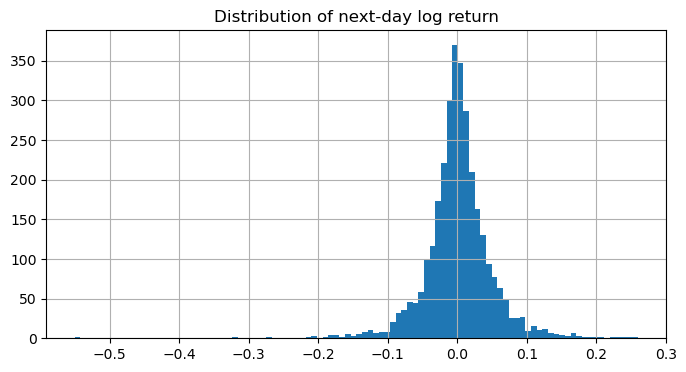

count    3177.000000
mean        0.001395
std         0.048298
min        -0.550732
25%        -0.020135
50%         0.000633
75%         0.022336
max         0.260244
Name: y_log_ret_1d_next, dtype: float64


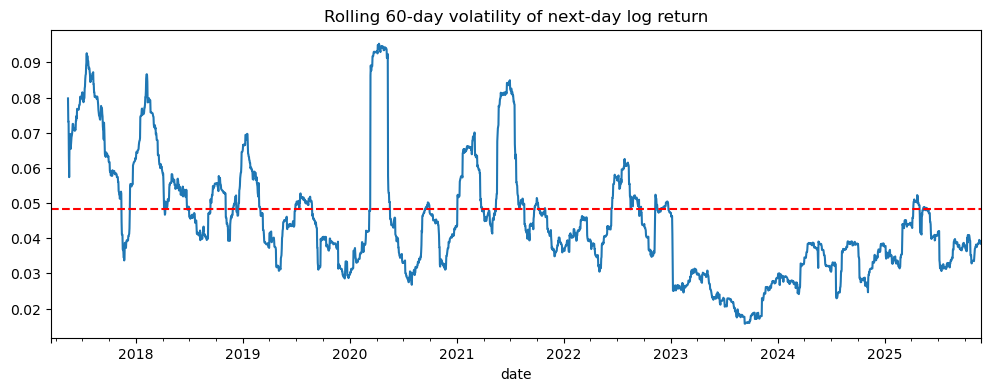

In [15]:
# distribution (hist)
eth["y_log_ret_1d_next"].hist(bins=100, figsize=(8,4))
plt.title("Distribution of next-day log return")
plt.show()

# summary stats
print(eth["y_log_ret_1d_next"].describe())

# rolling volatility
eth["y_log_ret_1d_next"].rolling(60).std().plot(figsize=(12,4))
plt.title("Rolling 60-day volatility of next-day log return")
plt.axhline(eth["y_log_ret_1d_next"].std(), color="red", linestyle="--")
plt.show()
